In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random


from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/ctrl_sst.nc", chunks = {'time':12})

VC = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/VAR_PACE_sst.nc", chunks = {"time":12})
po_pace_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/sst.nc", chunks = {"time":12})
oc_pace_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/obs_c_sst.nc", chunks = {"time":12})

def regrid_ACCESS(ds):
    #rename coords
    ds = ds.rename({"geolon_t": "longitude", "geolat_t": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds['sst'].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

VC = regrid_ACCESS(VC)
VC = VC.compute()

MC = regrid_ACCESS(po_pace_sst)
MC = MC.compute()

OC = regrid_ACCESS(oc_pace_sst)
OC = OC.compute()

ctrl = regrid_ACCESS(ctrl_sst)
ctrl = ctrl.compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, cal

In [33]:
#load in t100 for 3 experiemnets
ctrl100 = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/ctrl_100_t.nc", chunks = {'time':12}).__xarray_dataarray_variable__

VC100 = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/VC_100_t.nc", chunks = {'time':12}).__xarray_dataarray_variable__
OC100 = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/OC_100_t.nc", chunks = {'time':12}).__xarray_dataarray_variable__
ctrl100 = ctrl100.load()
VC100 = VC100.load()
OC100 = OC100.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, cal

In [2]:
import scipy.stats as stats

In [3]:
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def NINO34_sst(DS):
     return (DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
def NINO34(DS):
     return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
def iobm(DS):
     return ssta(DS).sel(latitude=slice(-20, 20),longitude=slice(40, 110)).mean(['latitude', 'longitude'])
    
def dmi(DS):
    WTIO = ssta(DS).sel(latitude=slice(-10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    SETIO = ssta(DS).sel(latitude=slice(-10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return  WTIO-SETIO
def siod(DS):
    west = ssta(DS).sel(latitude=slice(-37, -27),longitude=slice(55, 65)).mean(['latitude', 'longitude'])
    east = ssta(DS).sel(latitude=slice(-28, -18),longitude=slice(90, 100)).mean(['latitude', 'longitude'])
    return  west-east
def Ningaloo2(DS):
    return ssta(DS).sel(latitude=slice(-28, -22),longitude=slice(112, 114)).mean(['latitude', 'longitude'])

In [58]:
def plot_trendline(ds):
    x = np.arange(0, len(ds.time),1)
    y = ds
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    trend_line = slope * x + intercept
    equation_label = f'y = {slope:.2e}x + {intercept:.2e}'
    plt.plot(ds.time, trend_line, label=equation_label)
    return

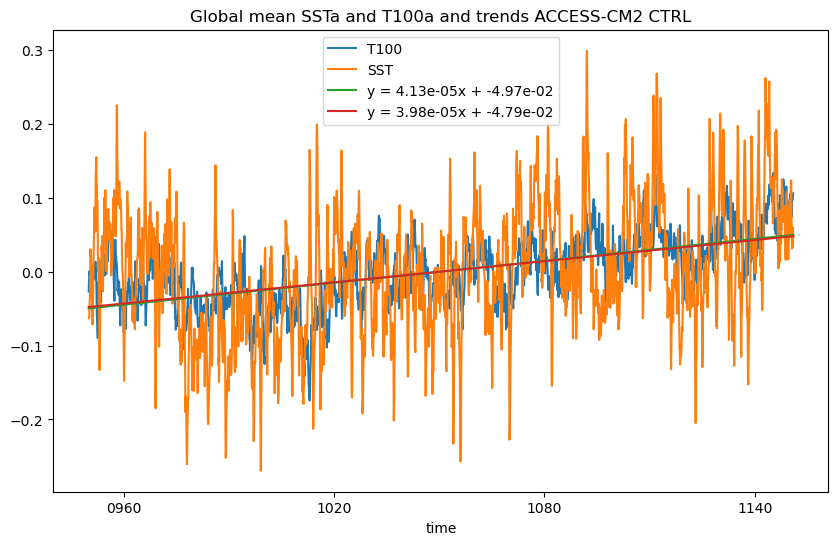

In [78]:
plt.figure(figsize = (10,6))
(ctrl100.groupby('time.month') - ctrl100.groupby('time.month').mean('time')).mean(['latitude', 'longitude']).plot(label = "T100")
(ctrl.groupby('time.month') - ctrl.groupby('time.month').mean('time')).mean(['latitude', 'longitude']).plot(label = "SST")
plot_trendline((ctrl100.groupby('time.month') - ctrl100.groupby('time.month').mean('time')).mean(['latitude', 'longitude']))
plot_trendline((ctrl.groupby('time.month') - ctrl.groupby('time.month').mean('time')).mean(['latitude', 'longitude']))
plt.title("Global mean SSTa and T100a and trends ACCESS-CM2 CTRL")
plt.legend()

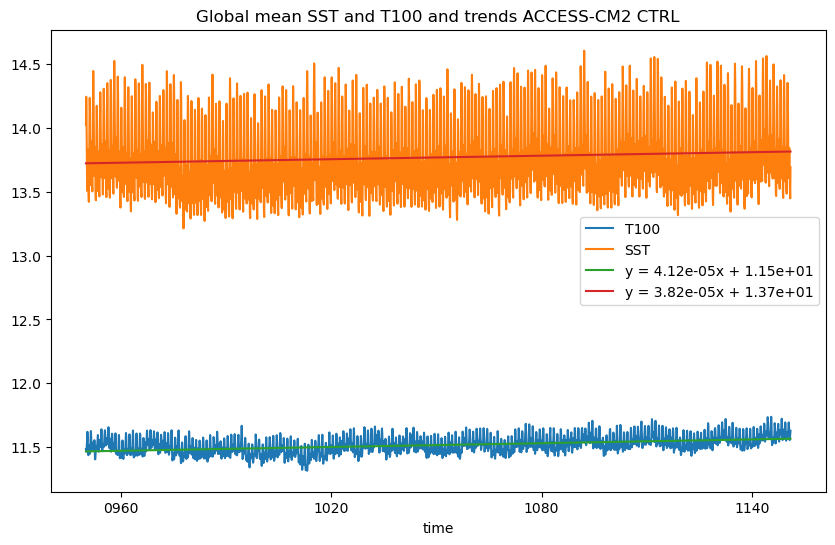

In [61]:
plt.figure(figsize = (10,6))
ctrl100.mean(['latitude', 'longitude']).plot(label = "T100")
ctrl.mean(['latitude', 'longitude']).plot(label = "SST")
plot_trendline(ctrl100.mean(['latitude', 'longitude']))
plot_trendline(ctrl.mean(['latitude', 'longitude']))
plt.title("Global mean SST and T100 and trends ACCESS-CM2 CTRL")
plt.legend()

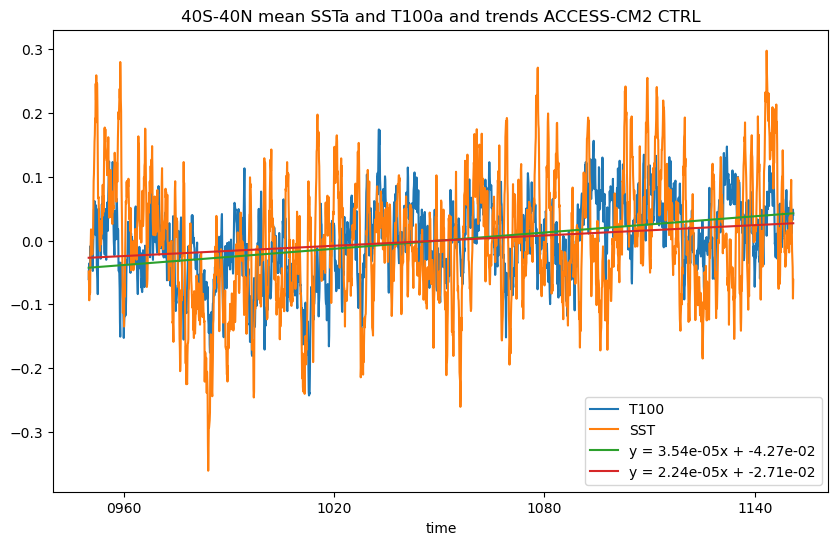

In [80]:
plt.figure(figsize = (10,6))
(ctrl100.groupby('time.month') - ctrl100.groupby('time.month').mean('time')).sel(latitude=slice(-40,40)).mean(['latitude', 'longitude']).plot(label = "T100")
(ctrl.groupby('time.month') - ctrl.groupby('time.month').mean('time')).sel(latitude=slice(-40,40)).mean(['latitude', 'longitude']).plot(label = "SST")
plot_trendline((ctrl100.groupby('time.month') - ctrl100.groupby('time.month').mean('time')).sel(latitude=slice(-40,40)).mean(['latitude', 'longitude']))
plot_trendline((ctrl.groupby('time.month') - ctrl.groupby('time.month').mean('time')).sel(latitude=slice(-40,40)).mean(['latitude', 'longitude']))
plt.title("40S-40N mean SSTa and T100a and trends ACCESS-CM2 CTRL")
plt.legend()

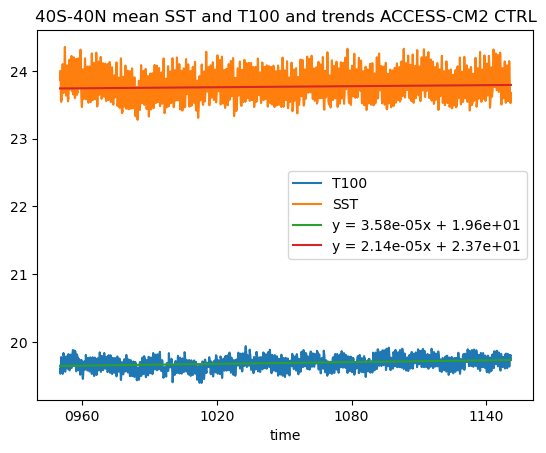

In [74]:
#plt.figure(figsize = (6,6))
ctrl100.sel(latitude=slice(-40,40)).mean(['latitude', 'longitude']).plot(label = "T100")
ctrl.sel(latitude=slice(-40,40)).mean(['latitude', 'longitude']).plot(label = "SST")
plot_trendline(ctrl100.sel(latitude=slice(-40,40)).mean(['latitude', 'longitude']))
plot_trendline(ctrl.sel(latitude=slice(-40,40)).mean(['latitude', 'longitude']))
plt.title("40S-40N mean SST and T100 and trends ACCESS-CM2 CTRL")
plt.legend()

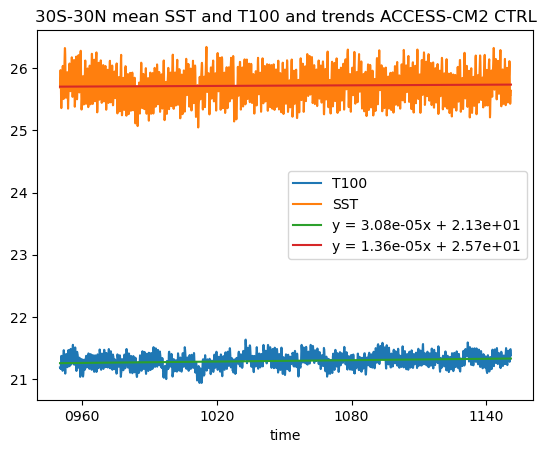

In [72]:
#plt.figure(figsize = (6,4))
ctrl100.sel(latitude=slice(-30,30)).mean(['latitude', 'longitude']).plot(label = "T100")
ctrl.sel(latitude=slice(-30,30)).mean(['latitude', 'longitude']).plot(label = "SST")
plot_trendline(ctrl100.sel(latitude=slice(-30,30)).mean(['latitude', 'longitude']))
plot_trendline(ctrl.sel(latitude=slice(-30,30)).mean(['latitude', 'longitude']))
plt.title("30S-30N mean SST and T100 and trends ACCESS-CM2 CTRL")
plt.legend()

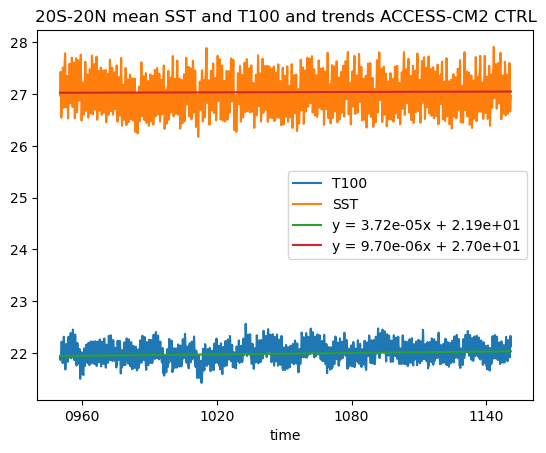

In [75]:
#plt.figure(figsize = (6,4))
ctrl100.sel(latitude=slice(-20,20)).mean(['latitude', 'longitude']).plot(label = "T100")
ctrl.sel(latitude=slice(-20,20)).mean(['latitude', 'longitude']).plot(label = "SST")
plot_trendline(ctrl100.sel(latitude=slice(-20,20)).mean(['latitude', 'longitude']))
plot_trendline(ctrl.sel(latitude=slice(-20,20)).mean(['latitude', 'longitude']))
plt.title("20S-20N mean SST and T100 and trends ACCESS-CM2 CTRL")
plt.legend()

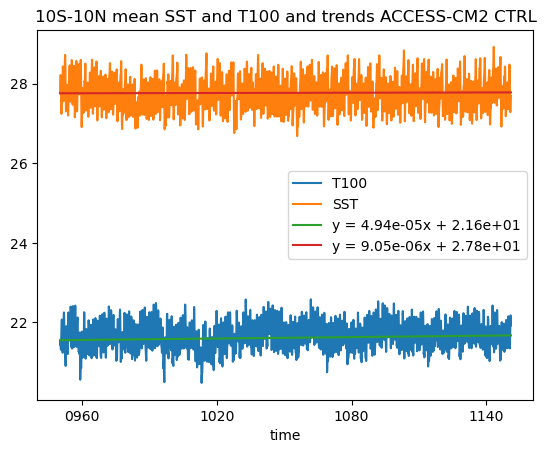

In [76]:
#plt.figure(figsize = (6,4))
ctrl100.sel(latitude=slice(-10,10)).mean(['latitude', 'longitude']).plot(label = "T100")
ctrl.sel(latitude=slice(-10,10)).mean(['latitude', 'longitude']).plot(label = "SST")
plot_trendline(ctrl100.sel(latitude=slice(-10,10)).mean(['latitude', 'longitude']))
plot_trendline(ctrl.sel(latitude=slice(-10,10)).mean(['latitude', 'longitude']))
plt.title("10S-10N mean SST and T100 and trends ACCESS-CM2 CTRL")
plt.legend()

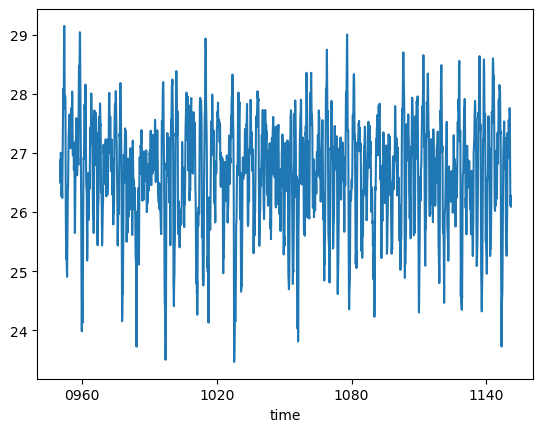

In [77]:
NINO34_sst(ctrl).plot(label = "SST")


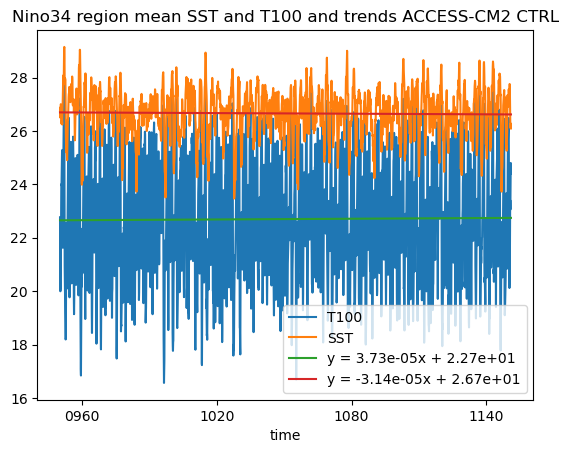

In [73]:
#plt.figure(figsize = (10,6))
NINO34_sst(ctrl100).plot(label = "T100")
NINO34_sst(ctrl).plot(label = "SST")
plot_trendline(NINO34_sst(ctrl100))
plot_trendline(NINO34_sst(ctrl))
plt.title("Nino34 region mean SST and T100 and trends ACCESS-CM2 CTRL")
plt.legend()

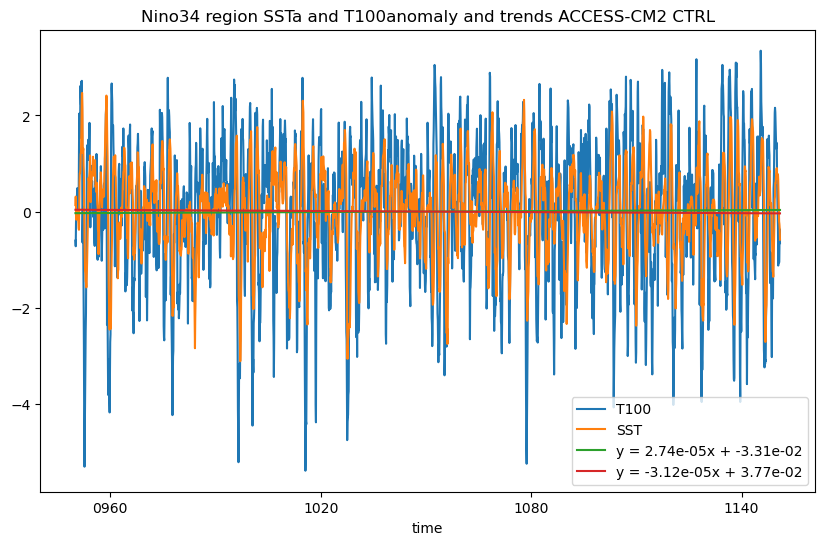

In [65]:
plt.figure(figsize = (10,6))
NINO34(ctrl100).plot(label = "T100")
NINO34(ctrl).plot(label = "SST")
plot_trendline(NINO34(ctrl100))
plot_trendline(NINO34(ctrl))
plt.title("Nino34 region SSTa and T100anomaly and trends ACCESS-CM2 CTRL")
plt.legend()

In [5]:
DMI = dmi(ctrl)

In [6]:
# Step 1: Number of iterations
num_iterations = 1000

In [44]:
# Step 2 and 3: Loop over the iterations
std_deviations = []
for _ in range(num_iterations):
    # Step 2: Randomly select 30 years with replacement
    random_years = np.random.choice(DMI['time.year'], size=30, replace=True)

    # Step 3: Calculate the standard deviation for the selected 30 years
    selected_years_data = DMI.sel(time=np.isin(DMI['time.year'], random_years))
    std_dev = selected_years_data.groupby('time.month').std(dim='time')

    # Step 4: Store the standard deviation value
    std_deviations.append(std_dev)

In [45]:
std_deviations_a = xr.concat(std_deviations, dim='iterations')


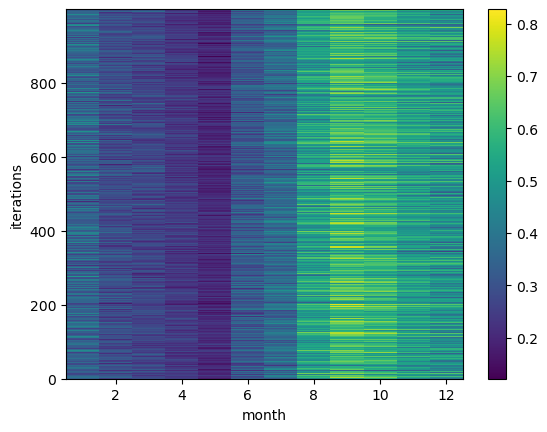

In [46]:
std_deviations_a.plot()

In [40]:
stats.f_oneway(std_deviations)#, axis = 1)

TypeError: at least two inputs are required; got 1.

In [ ]:
std_deviations

In [ ]:
#setp 0 get the index
da = index(ctrl)
#index_std_dev = da.groupby('time.month').std('time')
# Step 1: Number of iterations
num_iterations = 1000
# Step 2 and 3: Loop over the iterations
std_deviations = []
for _ in range(num_iterations):
    # Step 2: Randomly select 30 years with replacement
    random_years = np.random.choice(da['time.year'], size=30, replace=True)

    # Step 3: Calculate the standard deviation for the selected 30 years
    selected_years_data = da.sel(time=np.isin(da['time.year'], random_years))
    std_dev = selected_years_data.groupby('time.month').std(dim='time')

    # Step 4: Store the standard deviation value
    std_deviations.append(std_dev)

    # Step 5: Calculate the 5th and 95th percentiles
    std_deviations = xr.concat(std_deviations, dim='iterations')
    percentiles = std_deviations.quantile([0.05, 0.95], dim = 'iterations')
    #now we can produe the plot:
    plt.figure(figsize = (10,6))
    plt.errorbar(index_std_dev.month, index_std_dev, yerr=[index_std_dev-percentiles[0], percentiles[1]-index_std_dev]
                 , fmt='-o', capsize=5, label = 'CTRL')
    index(MC).groupby('time.month').std('time').plot(label = "no_ENSO")
    index(OC).groupby('time.month').std('time').plot(label = "no_ENSO_no_bias")
    index(VC).groupby('time.month').std('time').plot(label = "ENSO_no_bias")
    plt.xlabel('month')
    plt.ylabel('standard deviation')
    plt.grid(True)
    plt.legend()
    return